# Data analysis from experiment 3:

## 1) Database analysis:

In [1]:
#Experiment number:
exp_num = 3

In [2]:
# I manually copy the following data from the experiment so that I know which database to read:
max_ruido_dB = -60 
add_noise = True 
snr = [-5, 20] 
tr_aug = [0.2, 3.1, 0.1] 
drr_aug = [-6, 19, 1]

filter_type = 'octave band' #Type of filter to use: ‘octave band’ or 'third octave band'
fs = 16000 # Audio samplerate.
order = 4 # Filter order
bands = [125, 250, 500, 1000, 2000, 4000, 8000] # Bands to analyze
random_state = 2222

#The database is:
db_name = f'data_base_{max_ruido_dB}_noise_{add_noise}_traug_{tr_aug[0]}_{tr_aug[1]}_{tr_aug[2]}_drraug_{drr_aug[0]}_{drr_aug[1]}_{drr_aug[2]}_snr_{snr[0]}_{snr[-1]}'

In [3]:
# I manually copy the network data within the experiment so that I can reconstruct the model

#Network parameters:
filters = [32, 18, 8, 4] 
kernel_size = [10, 5, 5, 5] 
activation = ['relu','relu','relu','relu'] 
pool_size = [2,2,2]
learning_rate = 0.001

In [4]:
# Import packages:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle
import numpy as np
from scipy import stats
from progress.bar import IncrementalBar
import matplotlib
import warnings

In [5]:
warnings.filterwarnings("ignore")

def read_dataset(band, db_name, sample_frac=1.0, random_state=None, type_data='train'):
    """Read and concatenate cached database partitions for a given band/split."""
    partitions = os.listdir(f'../cache/{db_name}')

    bar = IncrementalBar('Reading database', max=len(partitions))

    db = pd.DataFrame()
    for partition in partitions:
        # Load partition.
        aux_df = pd.read_pickle(f'../cache/{db_name}/{partition}')
        # Filter by band and split, then accumulate.
        filtered_df = aux_df.loc[(aux_df.band == band) & (aux_df.type_data == type_data)]
        db = pd.concat([db, filtered_df], ignore_index=True)
        bar.next()
    
    db = db.sample(frac=sample_frac, random_state=random_state)
    bar.finish()

    return db

In [6]:
summary_t30 = {'Band [Hz]': [], 'r': [], 'r_real': [], 'r_synthetic': [], 'r_augmented': [], 'r_mean': [], 'p': [], 'Audio files': [], 'Percentile 95': [], 'Max': [], 'Min': []}
summary_c50 = {'Band [Hz]': [], 'r': [], 'r_real': [], 'r_synthetic': [], 'r_augmented': [], 'r_mean': [], 'p': [], 'Audio files': [], 'Percentile 95': [], 'Max': [], 'Min': []}
summary_c80 = {'Band [Hz]': [], 'r': [], 'r_real': [], 'r_synthetic': [], 'r_augmented': [], 'r_mean': [], 'p': [], 'Audio files': [], 'Percentile 95': [], 'Max': [], 'Min': []}
summary_d50 = {'Band [Hz]': [], 'r': [], 'r_real': [], 'r_synthetic': [], 'r_augmented': [], 'r_mean': [], 'p': [], 'Audio files': [], 'Percentile 95': [], 'Max': [], 'Min': []}

partitions = os.listdir(f'../cache/{db_name}')
db = pd.DataFrame()
bar = IncrementalBar('Reading data base', max = len(partitions))
for partition in partitions:
    #Leo la base de datos:
    with open(f'../cache/{db_name}/{partition}', "rb") as fh:
        aux_df = pickle.load(fh)
    db = pd.concat([db, aux_df], ignore_index=True)
    bar.next()
bar.finish()
db.head()

,ReverbedAudio,type_data,band,descriptors,drr,tae,snr
0,F1s3|sintetica_Seed1596910076_Tr3.0|original,train,125,"[3.0380767400132034, -5.1599023220137035, -4.0...",-11.815970,"[-0.018390085483650554, 0.10967622516742857, 0...",15.241284
1,F1s3|sintetica_Seed1596910076_Tr3.0|original,train,250,"[3.0112091087813755, -6.094729256565521, -4.48...",-11.444407,"[-0.023796199515263048, 0.22044520843610982, 0...",-4.094633
2,F1s3|sintetica_Seed1596910076_Tr3.0|original,train,500,"[2.975401768880005, -4.935279463780762, -2.948...",-10.640080,"[-0.015361002703654498, 0.1662005264116437, 0....",3.449357
3,F1s3|sintetica_Seed1596910076_Tr3.0|original,train,1000,"[2.9931469361903464, -7.3057264475659, -4.3147...",-11.535849,"[-0.011931395253797404, 0.14929680390561814, 0...",15.302383
4,F1s3|sintetica_Seed1596910076_Tr3.0|original,train,2000,"[2.9958027506907308, -5.596703417764175, -3.14...",-12.631823,"[-0.01903658507456845, 0.3305744464345736, 0.5...",1.798664


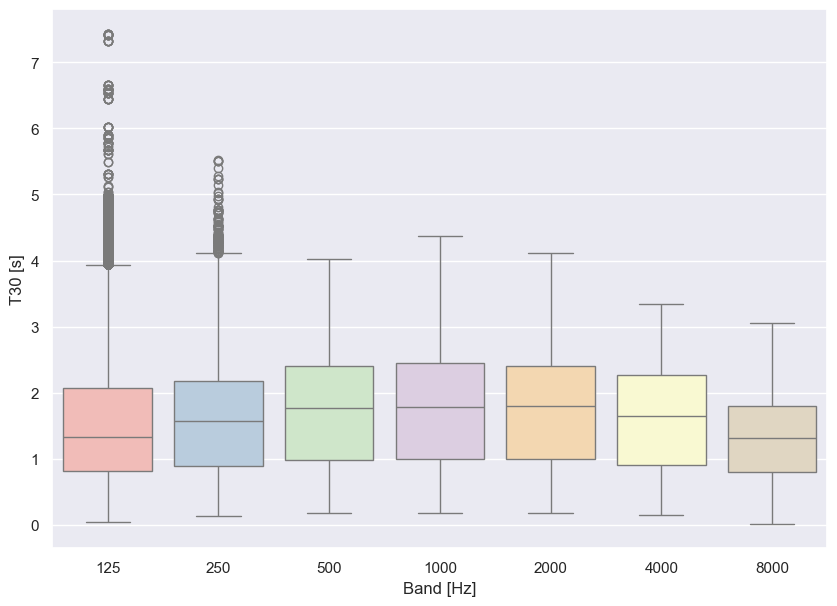

: 

In [ ]:
# Boxplot of T30 values by frequency band:

df_boxplot = pd.DataFrame({'Band [Hz]': db.band.to_list(), 
                           'DRR [dB]': db.drr.to_list(), 
                           'T30 [s]': list(map(lambda x: x[0], db.descriptors.to_list()))})

#plt.figure(figsize=(10,7))
sns.set(rc={'figure.figsize': (10, 7)})
sns.boxplot(x='Band [Hz]', y='T30 [s]', data=df_boxplot, palette="Pastel1")
plt.show()

In [ ]:
# Boxplot of DRR values by frequency band:

#plt.figure(figsize=(10,7))
sns.set(rc={'figure.figsize': (10, 7)})
sns.boxplot(x='Band [Hz]', y='DRR [dB]', data=df_boxplot, palette="Pastel1")
plt.show()

In [ ]:
# See how many audio files there are per band:
bands = [125, 250, 500, 1000, 2000, 4000, 8000]

for band in bands:

    tot_data_per_band = len(db.loc[db.band == band])
    
    db_band = db.loc[db.band == band]
    descriptors = db_band.descriptors.to_numpy()

    t30, c50, c80, d50 = [], [], [], []
    for values in descriptors:
        t30.append(values[0])
        c50.append(values[1])
        c80.append(values[2])
        d50.append(values[3])

    summary_t30['Audio files'].append(tot_data_per_band)
    summary_t30['Percentile 95'].append(np.round(np.percentile(t30, 95),3))
    summary_t30['Max'].append(np.round(np.max(t30),3))
    summary_t30['Min'].append(np.round(np.min(t30),3))

    summary_c50['Audio files'].append(tot_data_per_band)
    summary_c50['Percentile 95'].append(np.round(np.percentile(c50, 95),3))
    summary_c50['Max'].append(np.round(np.max(c50),3))
    summary_c50['Min'].append(np.round(np.min(c50),3))

    summary_c80['Audio files'].append(tot_data_per_band)
    summary_c80['Percentile 95'].append(np.round(np.percentile(c80, 95),3))
    summary_c80['Max'].append(np.round(np.max(c80),3))
    summary_c80['Min'].append(np.round(np.min(c80),3))

    summary_d50['Audio files'].append(tot_data_per_band)
    summary_d50['Percentile 95'].append(np.round(np.percentile(d50, 95),3))
    summary_d50['Max'].append(np.round(np.max(d50),3))
    summary_d50['Min'].append(np.round(np.min(d50),3))

In [ ]:
# Reverberation time by band and by room:

great_hall = {'Name': [], 'Band': [], 'T30': []}
octagon = {'Name': [], 'Band': [], 'T30': []}
classroom = {'Name': [], 'Band': [], 'T30': []}

for i in range(len(db)):

    if ('great_hall' in db.ReverbedAudio[i]) and ('original' in db.ReverbedAudio[i]):
        great_hall['Name'].append(db.ReverbedAudio[i].split('|')[1])
        great_hall['Band'].append(db.band[i])
        great_hall['T30'].append(db.descriptors[i][0])

    elif ('octagon' in db.ReverbedAudio[i]) and ('original' in db.ReverbedAudio[i]):
        octagon['Name'].append(db.ReverbedAudio[i].split('|')[1])
        octagon['Band'].append(db.band[i])
        octagon['T30'].append(db.descriptors[i][0])

    elif ('classroom' in db.ReverbedAudio[i]) and ('original' in db.ReverbedAudio[i]):
        classroom['Name'].append(db.ReverbedAudio[i].split('|')[1])
        classroom['Band'].append(db.band[i])
        classroom['T30'].append(db.descriptors[i][0])

df_great_hall = pd.DataFrame(great_hall)
df_octagon = pd.DataFrame(octagon)
df_classroom = pd.DataFrame(classroom)


for band in bands:
    print(f'\nBand {band}:\n')
    df_great_hall_band = df_great_hall.loc[df_great_hall.Band == band]
    df_octagon_band = df_octagon.loc[df_octagon.Band == band]
    df_classroom_band = df_classroom.loc[df_classroom.Band == band]

    print(f'great_hall: Mean: {np.round(np.mean(df_great_hall_band.T30.to_numpy()),2)}, Standard deviation: {np.round(np.std(df_great_hall_band.T30.to_numpy()),2)}')
    print(f'octagon: Mean: {np.round(np.mean(df_octagon_band.T30.to_numpy()),2)}, Standard deviation: {np.round(np.std(df_octagon_band.T30.to_numpy()),2)}')
    print(f'classroom: Mean: {np.round(np.mean(df_classroom_band.T30.to_numpy()),2)}, Standard deviation: {np.round(np.std(df_classroom_band.T30.to_numpy()),2)}')


In [ ]:
# Scatterplots of the mean values of the T30 and DRR descriptors for synthetic audio:

mid_bands = [500, 1000] # Bands that make up the calculation for T30_mid, DRR_mid, C50_mid, C80_mid, and D50_mid

T30_mid, DRR_mid = [], []

T30_500, T30_1000 = 0, 0
DRR_500, DRR_1000 = 0, 0

names = db.ReverbedAudio.to_numpy()

for i in range(len(db)):

    if 'sintetica' in db.ReverbedAudio[i]:

        if db.band[i] == 500:
            T30_500 = db.descriptors[i][0]
            DRR_500 = db.drr[i]

        elif db.band[i] == 1000:
            T30_1000 = db.descriptors[i][0]
            DRR_1000 = db.drr[i]

        if (names[i] == names[i-1]) and (T30_500 != 0) and (T30_1000 != 0):
            T30_mid.append(np.mean([T30_500, T30_1000]))
            DRR_mid.append(np.mean([DRR_500, DRR_1000]))

            T30_500, T30_1000 = 0, 0
            DRR_500, DRR_1000 = 0, 0
    
    else:
        pass

print('Values for synthetic RIRs')

plt.figure(figsize=(10,7))
plt.plot(T30_mid, DRR_mid, linestyle='', marker='o', alpha=0.5)
plt.xlabel('T30_mid [s]', size=15)
plt.ylabel('DRR_mid [dB]', size=15)
plt.xlim((0, 4))
plt.ylim((-18, 18))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()
#plt.title('Scatter plot entre el T30_mid y DRR_mid:', loc='left')
matplotlib.rcParams.update({'font.size': 25})
plt.tight_layout()
plt.show()

In [ ]:
# Scatterplots of the mean values of the T30 and DRR descriptors for real audio:

mid_bands = [500, 1000] # Bands that make up the calculation for T30_mid, DRR_mid, C50_mid, C80_mid, and D50_mid

T30_mid, DRR_mid = [], []

T30_500, T30_1000 = 0, 0
DRR_500, DRR_1000 = 0, 0

names = db.ReverbedAudio.to_numpy()

for i in range(len(db)):

    great_hall = ('great_hall' in db.ReverbedAudio[i]) and ('original' in db.ReverbedAudio[i])
    octagon = (('octagon' in db.ReverbedAudio[i]) and ('original' in db.ReverbedAudio[i]))
    classroom = (('classroom' in db.ReverbedAudio[i]) and ('original' in db.ReverbedAudio[i]))

    if  great_hall or octagon or classroom:

        if db.band[i] == 500:
            T30_500 = db.descriptors[i][0]
            DRR_500 = db.drr[i]

        elif db.band[i] == 1000:
            T30_1000 = db.descriptors[i][0]
            DRR_1000 = db.drr[i]

        if (names[i] == names[i-1]) and (T30_500 != 0) and (T30_1000 != 0):
            T30_mid.append(np.mean([T30_500, T30_1000]))
            DRR_mid.append(np.mean([DRR_500, DRR_1000]))

            T30_500, T30_1000 = 0, 0
            DRR_500, DRR_1000 = 0, 0
    
    else:
        pass

print('Values for real RIRs')

plt.figure(figsize=(10,7))
plt.plot(T30_mid, DRR_mid, linestyle='', marker='o', alpha=0.5)
plt.xlabel('T30_mid [s]', size=15)
plt.ylabel('DRR_mid [dB]', size=15)
plt.xlim((0, 4))
plt.ylim((-18, 18))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()
#plt.title('Scatter plot entre el T30_mid y DRR_mid:', loc='left')
matplotlib.rcParams.update({'font.size': 25})
plt.tight_layout()
plt.show()

In [ ]:
# Scatterplots of the mean values of the T30 and DRR descriptors for augmented audio:

mid_bands = [500, 1000] # Bands that make up the calculation for T30_mid, DRR_mid, C50_mid, C80_mid, and D50_mid

T30_mid, DRR_mid = [], []

T30_500, T30_1000 = 0, 0
DRR_500, DRR_1000 = 0, 0

names = db.ReverbedAudio.to_numpy()

for i in range(len(db)):

    if ('TR_var_' in db.ReverbedAudio[i]) or ('DRR_var_' in db.ReverbedAudio[i]):

        if db.band[i] == 500:
            T30_500 = db.descriptors[i][0]
            DRR_500 = db.drr[i]

        elif db.band[i] == 1000:
            T30_1000 = db.descriptors[i][0]
            DRR_1000 = db.drr[i]

        if (names[i] == names[i-1]) and (T30_500 != 0) and (T30_1000 != 0):
            T30_mid.append(np.mean([T30_500, T30_1000]))
            DRR_mid.append(np.mean([DRR_500, DRR_1000]))

            T30_500, T30_1000 = 0, 0
            DRR_500, DRR_1000 = 0, 0
    
    else:
        pass

print('Values for augmented RIRs')

plt.figure(figsize=(10,7))
plt.plot(T30_mid, DRR_mid, linestyle='', marker='o', alpha=0.5)
plt.xlabel('T30_mid [s]', size=15)
plt.ylabel('DRR_mid [dB]', size=15)
plt.xlim((0, 4))
plt.ylim((-18, 18))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()
#plt.title('Scatter plot entre el T30_mid y DRR_mid:', loc='left')
matplotlib.rcParams.update({'font.size': 25})
plt.tight_layout()
plt.show()

In [ ]:
# Scatterplots of the mean values of the T30 and DRR descriptors for the entire database:

mid_bands = [500, 1000] # Bands that make up the calculation for T30_mid, DRR_mid, C50_mid, C80_mid, and D50_mid

T30_mid, DRR_mid = [], []

T30_500, T30_1000 = 0, 0
DRR_500, DRR_1000 = 0, 0

names = db.ReverbedAudio.to_numpy()

for i in range(len(db)):

    if db.band[i] == 500:
        T30_500 = db.descriptors[i][0]
        DRR_500 = db.drr[i]

    elif db.band[i] == 1000:
        T30_1000 = db.descriptors[i][0]
        DRR_1000 = db.drr[i]

    if (names[i] == names[i-1]) and (T30_500 != 0) and (T30_1000 != 0):
        T30_mid.append(np.mean([T30_500, T30_1000]))
        DRR_mid.append(np.mean([DRR_500, DRR_1000]))

        T30_500, T30_1000 = 0, 0
        DRR_500, DRR_1000 = 0, 0
    

print('Values for RIRs in the entire database')

plt.figure(figsize=(10,7))
plt.plot(T30_mid, DRR_mid, linestyle='', marker='o', alpha=0.5)
plt.xlabel('T30_mid [s]', size=15)
plt.ylabel('DRR_mid [dB]', size=15)
plt.xlim((0, 4))
plt.ylim((-18, 18))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()
#plt.title('Scatter plot entre el T30_mid y DRR_mid:', loc='left')
matplotlib.rcParams.update({'font.size': 25})
plt.tight_layout()
plt.show()

In [ ]:
print(f'Max tr_mid {np.max(T30_mid)}, max drr {np.max(DRR_mid)}')
print(f'Min tr_mid {np.min(T30_mid)}, min drr {np.min(DRR_mid)}')

**Calculate the Pearson correlation coefficient (r):**

In [ ]:
descriptors_perc = ['T30_perc_95', 'C50_perc_95', 'C80_perc_95', 'D50_perc_95']

for band in bands:
    # Add band
    summary_t30['Band [Hz]'].append(band)
    summary_c50['Band [Hz]'].append(band)
    summary_c80['Band [Hz]'].append(band)
    summary_d50['Band [Hz]'].append(band)

    # Read training results
    with open(f'../results/exp{exp_num}/results_{band}.pickle', 'rb') as handle:
        results = pickle.load(handle)

    db_test = read_dataset(band, db_name, 1.0, random_state, type_data='test')

    db_reals = db_test[db_test.ReverbedAudio.str.lower().str.contains("original")]
    idx_reals = db_reals[~db_reals.ReverbedAudio.str.lower().str.contains("sintetica")].index.values.tolist()

    idx_synthetics = db_test[db_test.ReverbedAudio.str.lower().str.contains("sintetica")].index.values.tolist()
    db_augmented = db_test[~db_test.ReverbedAudio.str.lower().str.contains("DRR_var_|TR_var_")]
    idx_augmented = db_augmented[~db_augmented.ReverbedAudio.str.lower().str.contains("sintetica")].index.values.tolist()

    for idx_perc, perc_type in enumerate(descriptors_perc):
        x_mean_reals, y_mean_reals = [], []
        x_mean_synthetics, y_mean_synthetics = [], []
        x_mean_augmented, y_mean_augmented = [], []
        
        x = [np.round(results['prediction'][i][idx_perc] * results[perc_type],2) for i in range(len(results['y_test']))]
        y = [np.round(results['y_test'][i,:,0].reshape(1,-1,1).flatten()[idx_perc] * results[perc_type] ,2)  for i in range(len(results['y_test']))]

        if len(idx_reals) == 0:
            r_reals_mean = 0

            for i in idx_synthetics:
                x_mean_synthetics.append(np.round(results['prediction'][i][idx_perc] * results[perc_type],2))
                y_mean_synthetics.append(np.round(results['y_test'][i,:,0].reshape(1,-1,1).flatten()[idx_perc] * results[perc_type] ,2))

            for i in idx_augmented:
                x_mean_augmented.append(np.round(results['prediction'][i][idx_perc] * results[perc_type],2))
                y_mean_augmented.append(np.round(results['y_test'][i,:,0].reshape(1,-1,1).flatten()[idx_perc] * results[perc_type] ,2))
            
            r_synt_mean = np.round(stats.spearmanr(x_mean_synthetics, y_mean_synthetics)[0],3)
            r_aum_mean = np.round(stats.spearmanr(x_mean_augmented, y_mean_augmented)[0],3)


        else:

            for i in idx_reals:
                x_mean_reals.append(np.round(results['prediction'][i][idx_perc] * results[perc_type],2))
                y_mean_reals.append(np.round(results['y_test'][i,:,0].reshape(1,-1,1).flatten()[idx_perc] * results[perc_type] ,2))

            for i in idx_synthetics:
                x_mean_synthetics.append(np.round(results['prediction'][i][idx_perc] * results[perc_type],2))
                y_mean_synthetics.append(np.round(results['y_test'][i,:,0].reshape(1,-1,1).flatten()[idx_perc] * results[perc_type] ,2))

            for i in idx_augmented:
                x_mean_augmented.append(np.round(results['prediction'][i][idx_perc] * results[perc_type],2))
                y_mean_augmented.append(np.round(results['y_test'][i,:,0].reshape(1,-1,1).flatten()[idx_perc] * results[perc_type] ,2))

            r_reals_mean = np.round(stats.spearmanr(x_mean_reals, y_mean_reals)[0],3)
            r_synt_mean = np.round(stats.spearmanr(x_mean_synthetics, y_mean_synthetics)[0],3)
            r_aum_mean = np.round(stats.spearmanr(x_mean_augmented, y_mean_augmented)[0],3)


        if idx_perc == 0:
            summary_t30['r'].append(np.round(stats.spearmanr(x, y)[0],3))
            summary_t30['p'].append(np.round(stats.spearmanr(x, y)[1],3))
            summary_t30['r_mean'].append((r_reals_mean+r_synt_mean+r_aum_mean)/3)
            summary_t30['r_real'].append(r_reals_mean)
            summary_t30['r_synthetic'].append(r_synt_mean)
            summary_t30['r_augmented'].append(r_aum_mean)

        elif idx_perc == 1:
            summary_c50['r'].append(np.round(stats.spearmanr(x, y)[0],3))
            summary_c50['p'].append(np.round(stats.spearmanr(x, y)[1],3))
            summary_c50['r_mean'].append((r_reals_mean+r_synt_mean+r_aum_mean)/3)
            summary_c50['r_real'].append(r_reals_mean)
            summary_c50['r_synthetic'].append(r_synt_mean)
            summary_c50['r_augmented'].append(r_aum_mean)

        elif idx_perc == 2:
            summary_c80['r'].append(np.round(stats.spearmanr(x, y)[0],3))
            summary_c80['p'].append(np.round(stats.spearmanr(x, y)[1],3))
            summary_c80['r_mean'].append((r_reals_mean+r_synt_mean+r_aum_mean)/3)
            summary_c80['r_real'].append(r_reals_mean)
            summary_c80['r_synthetic'].append(r_synt_mean)
            summary_c80['r_augmented'].append(r_aum_mean)

        elif idx_perc == 3:
            summary_d50['r'].append(np.round(stats.spearmanr(x, y)[0],3))
            summary_d50['p'].append(np.round(stats.spearmanr(x, y)[1],3))
            summary_d50['r_mean'].append((r_reals_mean+r_synt_mean+r_aum_mean)/3)
            summary_d50['r_real'].append(r_reals_mean)
            summary_d50['r_synthetic'].append(r_synt_mean)
            summary_d50['r_augmented'].append(r_aum_mean)

## 2) Estimation using the trained model:

In [ ]:
from sklearn.model_selection import train_test_split
from scipy.signal import butter
from librosa import load
import sys
import os
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../code')
sys.path.append('../code/cpp/build/Release')
import model
from filters import BandpassFilter
from audio_processing import ClarityCalculator as clarity
from audio_processing import DefinitionCalculator as definition
from parameters_calculation import TAE
from parameters_calculation import tr_lundeby, NoiseError

bpfilter = BandpassFilter(filter_type, fs, order, bands) # Instance the filter class.

sos_lowpass_filter = butter(order, 20, fs=fs, btype='lowpass', output='sos')

blind_estimation_model = model.model(filters, kernel_size, activation, pool_size, learning_rate)

In [ ]:
def get_parameters(rir, filter_):
    
    filtered_rir = filter_.filtered_signals(rir)

    rir_parameters = []
    for audio in filtered_rir:
        t30, _, _ = tr_lundeby(audio, fs, max_ruido_dB)
        c50 = clarity.calculate(50, audio, fs)
        c80 = clarity.calculate(80, audio, fs)
        d50 = definition.calculate(audio, fs)

        rir_parameters.append([np.round(t30,3), np.round(c50,3), np.round(c80,3), np.round(d50,3)])

    return rir_parameters

def get_tae_per_band(speech, filter_, fs, sos_lowpass):
    
    filtered_speech = filter_.filter_signals(list(speech))

    tae_per_band = []
    for audio in filtered_speech:
        audio = audio/np.max(np.abs(audio))
        tae_per_band.append(TAE(audio, fs, sos_lowpass))
    
    return tae_per_band

### Room 1

In [ ]:
files = [file for file in os.listdir('../data/Measurements/room1') if '.wav' in file]

room_1 = {'Name': [], 'Audio type': [], 'Band': [] ,'Result': []}

data_to_estimate = []
for file in files:
    
    if 'Rir' in file:
        continue
    
    else:
        speech, _ = load(f'../data/Measurements/room1/{file}', sr=fs, duration=5.0)
        tae_speech = get_tae_per_band(speech, bpfilter, fs, sos_lowpass_filter)

        tae_list = []
        for i in range(len(tae_speech)):
            tae_list.append(np.array(tae_speech[i]).reshape(-1, 1))

        tae_list = np.array(tae_list)
        for i, band in enumerate(bands):

            blind_estimation_model.load_weights(f'../results/exp{exp_num}/weights_{band}.weights.h5')

            with open(f'../results/exp{exp_num}/results_{band}.pickle', 'rb') as handle:
                perc = pickle.load(handle)

            room_1['Name'].append(file)
            room_1['Audio type'].append('Speech')
            room_1['Band'].append(band)
            aux = np.round(blind_estimation_model.predict(tae_list[i,:,0].reshape(1,-1,1), verbose=0),3)[0]
            room_1['Result'].append([np.round(aux[0]*perc['T30_perc_95'], 3), 
                                        np.round(aux[1]*perc['C50_perc_95'], 3), 
                                        np.round(aux[2]*perc['C80_perc_95'], 3), 
                                        np.round(aux[3]*perc['D50_perc_95'], 3)])

In [ ]:
room_1_df = pd.DataFrame(room_1)

rew_room1 = pd.read_excel('../data/Measurements/room1/room1_rew.xlsx')

room_1_df = pd.concat([room_1_df, rew_room1], ignore_index=True).sort_values(by=['Band', 'Name'])

print(room_1_df.to_string())

### Room 2

In [ ]:
files = [file for file in os.listdir('../data/Measurements/room2') if '.wav' in file]
#files = os.listdir('../data/Measurements/room2')

room_2 = {'Name': [], 'Audio type': [], 'Band': [] ,'Result': []}

data_to_estimate = []
for file in files:
    
    if 'Rir' in file:
        continue
    
    else:
        speech, _ = load(f'../data/Measurements/room2/{file}', sr=fs, duration=5.0)
        tae_speech = get_tae_per_band(speech, bpfilter, fs, sos_lowpass_filter)

        tae_list = []
        for i in range(len(tae_speech)):
            tae_list.append(np.array(tae_speech[i]).reshape(-1, 1))

        tae_list = np.array(tae_list)
        for i, band in enumerate(bands):

            blind_estimation_model.load_weights(f'../results/exp{exp_num}/weights_{band}.weights.h5')

            with open(f'../results/exp{exp_num}/results_{band}.pickle', 'rb') as handle:
                perc = pickle.load(handle)

            room_2['Name'].append(file)
            room_2['Audio type'].append('Speech')
            room_2['Band'].append(band)
            aux = np.round(blind_estimation_model.predict(tae_list[i,:,0].reshape(1,-1,1), verbose=0),3)[0]
            room_2['Result'].append([np.round(aux[0]*perc['T30_perc_95'], 3), 
                                        np.round(aux[1]*perc['C50_perc_95'], 3), 
                                        np.round(aux[2]*perc['C80_perc_95'], 3), 
                                        np.round(aux[3]*perc['D50_perc_95'], 3)])

In [ ]:
room_2_df = pd.DataFrame(room_2)

rew_room2 = pd.read_excel('../data/Measurements/room2/room2_rew.xlsx')

room_2_df = pd.concat([room_2_df, rew_room2], ignore_index=True).sort_values(by=['Band', 'Name'])

print(room_2_df.to_string())

### Room 3

In [ ]:
files = [file for file in os.listdir('../data/Measurements/room3') if '.wav' in file]
#files = os.listdir('../data/Measurements/room3')

room_3 = {'Name': [], 'Audio type': [], 'Band': [] ,'Result': []}

data_to_estimate = []
for file in files:
    
    if 'Rir' in file:
        continue
    
    else:
        speech, _ = load(f'../data/Measurements/room3/{file}', sr=fs, duration=5.0)
        tae_speech = get_tae_per_band(speech, bpfilter, fs, sos_lowpass_filter)

        tae_list = []
        for i in range(len(tae_speech)):
            tae_list.append(np.array(tae_speech[i]).reshape(-1, 1))

        tae_list = np.array(tae_list)
        for i, band in enumerate(bands):

            blind_estimation_model.load_weights(f'../results/exp{exp_num}/weights_{band}.weights.h5')

            with open(f'../results/exp{exp_num}/results_{band}.pickle', 'rb') as handle:
                perc = pickle.load(handle)

            room_3['Name'].append(file)
            room_3['Audio type'].append('Speech')
            room_3['Band'].append(band)
            aux = np.round(blind_estimation_model.predict(tae_list[i,:,0].reshape(1,-1,1), verbose=0),3)[0]
            room_3['Result'].append([np.round(aux[0]*perc['T30_perc_95'], 3), 
                                        np.round(aux[1]*perc['C50_perc_95'], 3), 
                                        np.round(aux[2]*perc['C80_perc_95'], 3), 
                                        np.round(aux[3]*perc['D50_perc_95'], 3)])

In [ ]:
room_3_df = pd.DataFrame(room_3)

rew_room3 = pd.read_excel('../data/Measurements/room3/room3_rew.xlsx')

room_3_df = pd.concat([room_3_df, rew_room3], ignore_index=True).sort_values(by=['Band', 'Name'])

print(room_3_df.to_string())

## 3) Summary:

In [ ]:
print('T30 results analysis:\n')


results_t30 = pd.DataFrame(data=summary_t30)

print(results_t30)

In [ ]:
print('C50 results analysis:\n')

results_c50 = pd.DataFrame(data=summary_c50)

print(results_c50)

In [ ]:
print('C80 results analysis:\n')

results_c80 = pd.DataFrame(data=summary_c80)

print(results_c80)

In [ ]:
print('D50 results analysis:\n')

results_d50 = pd.DataFrame(data=summary_d50)

print(results_d50)